In [1]:
import sqlite3  # apt install sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import pyasn
import json

import Cdf  # from Think Stats 2e (Allen B. Downey): http://greenteapress.com/thinkstats/Cdf.py; requires http://greenteapress.com/thinkstats/Pmf.py

In [2]:
save_figures = False
export_cdf = False

In [3]:
def export_cdf_dist(cdf_obj, filename, metric, description=''):
    with open('cdf-pxs/%s.txt' % filename, 'a+') as f:
        print('===== %s (%s) =====' % (metric, description), file=f)
        skip = max(1, int(len(cdf_obj.xs)/200))
        for tup in list(zip(cdf_obj.ps, cdf_obj.xs))[::skip]:
            print(str(round(tup[0], 5)).ljust(7, '0') + ';\t' + str(round(tup[1], 5)), file=f)
        print('\n=========================\n', file=f)

In [4]:
conn = sqlite3.connect('merged.db')
msm_df = pd.read_sql('select * from measurements', con=conn).drop_duplicates()
tr_df = pd.read_sql('select * from traceroutes', con=conn).drop_duplicates()
conn.close()

Overview of collected metrics (from app source code documentation);  
- note: consider metrics not discussed in the paper as experimental
- missing from playback metrics table: ``time_to_load_web_page_ms`` (option not enabled in study)  

<div>
<img src="descriptions/video-metrics.png" width="700"/>
</div>

<div>
<img src="descriptions/traceroute-metrics.png" width="700"/>
</div>

## Pre-processing

- adjust units
- fill additional information

In [5]:
# pack relevant metrics and column names together
info = [('Startup Delay [s]', 'startup_delay_ms'),
        ('TCP Connect Time [ms]', 'tcp_connection_time_ms'),
        ('Stall Duration [ms]', 'stall_duration_ms'),
        ('Load Duration [s]', 'load_duration_ms'),
        ('Time to Reach Source [s]', 'time_to_reach_source_ms'),
        ('Initial Buffer Size [s]', 'initial_buffer_size_ms'),
        ('MiB loaded', 'bytes_loaded'),
        ('Content Duration [s]', 'content_duration_ms'),
        ('Total Played Duration [s]', 'total_played_duration_ms'),
        ('Bandwidth Estimate [Mbps]', 'bandwidth_estimate_bps'),
        ('Initial Exo Processing Time [ms]', 'initial_exo_processing_time_ms'),
       ]

divs = {'startup_delay_ms' : 1000,
        'load_duration_ms' : 1000,
        'time_to_reach_source_ms' : 1000,
        'initial_buffer_size_ms' : 1000,
        'bytes_loaded' : 1024*1024,
        'content_duration_ms' : 1000,
        'total_played_duration_ms' : 1000,
        'bandwidth_estimate_bps' : 1024*1024,
       }

for (desc, col) in info:
    msm_df = msm_df[msm_df[col] >= 0]
    try:
        msm_df[col] = msm_df[col]/divs[col]
    except:
        pass

In [6]:
msm_df['date_time'] = pd.to_datetime(msm_df['date_time'], format='%d-%m-%Y_%H:%M:%S').dt.floor('h')
msm_df['day'] = msm_df['date_time'].dt.day
msm_df['month'] = msm_df['date_time'].dt.month
msm_df['year'] = msm_df['date_time'].dt.year

In [7]:
# only take measurements until end of Nov 2019
msm_df = msm_df[msm_df['date_time'] < '2019-12-01']

In [8]:
msm_df.tail()

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,stall_duration_ms,bandwidth_estimate_bps,initial_exo_processing_time_ms,tcp_connection_time_ms,host,network_type,device,day,month,year
78367,1575146804426,youtube,https://r3---sn-4g5e6nzz.googlevideo.com/video...,https://www.youtube.com/watch?v=du4mlTBXQH8,1184,2019-11-30 21:00:00,0.341,0.000,12.071542,60.474,...,137,1.596923,12,22,r3---sn-4g5e6nzz.googlevideo.com,wifi,nexus-magenta,30,11,2019
78368,1575146872048,youtube,https://r2---sn-4g5e6nsd.googlevideo.com/video...,https://www.youtube.com/watch?v=ggjFHev0JIw,1112,2019-11-30 21:00:00,0.571,13.560,7.032560,60.439,...,132,0.930863,11,17,r2---sn-4g5e6nsd.googlevideo.com,wifi,nexus-magenta,30,11,2019
78369,1575146938307,dtube,https://video.dtube.top/ipfs/QmRJpRu7SSfhyg9pk...,https://d.tube/#!/v/rem-steem/QmRJpRu7SSfhyg9p...,20023,2019-11-30 21:00:00,0.667,2.669,53.603714,60.691,...,88,7.065787,10,30,video.dtube.top,wifi,nexus-magenta,30,11,2019
78370,1575147005722,dtube,https://video.dtube.top/ipfs/QmWfrZ8ABLvYTCvBo...,https://d.tube/#!/v/yummyrecipe/QmYJSnfQBLwMaZ...,9998,2019-11-30 21:00:00,0.597,11.520,7.006043,60.296,...,162,0.929553,10,25,video.dtube.top,wifi,nexus-magenta,30,11,2019
78371,1575147071887,dtube,https://video.dtube.top/ipfs/QmTkfYowWnLMgn39v...,https://d.tube/#!/v/frostyamber/QmVt47uaNKvuPd...,5174,2019-11-30 21:00:00,0.537,2.986,1.493686,9.749,...,0,7.881062,9,28,video.dtube.top,wifi,nexus-magenta,30,11,2019


In [9]:
pd.crosstab(msm_df['platform'], msm_df['network_type'], margins=True)

network_type,cellular,wifi,All
platform,,,
dtube,994,1820,2814
youtube,1663,4074,5737
All,2657,5894,8551


In [10]:
print(pd.crosstab(msm_df['platform'], msm_df['network_type'], margins=True).to_latex())

\begin{tabular}{lrrr}
\toprule
network\_type &  cellular &  wifi &   All \\
platform &           &       &       \\
\midrule
dtube    &       994 &  1820 &  2814 \\
youtube  &      1663 &  4074 &  5737 \\
All      &      2657 &  5894 &  8551 \\
\bottomrule
\end{tabular}



In [11]:
tr_df['date_time'] = pd.to_datetime(tr_df['date_time'], format='%d-%m-%Y_%H:%M:%S').dt.floor('h')
tr_df['day'] = tr_df['date_time'].dt.day
tr_df['month'] = tr_df['date_time'].dt.month
tr_df['year'] = tr_df['date_time'].dt.year

In [12]:
# only take measurements until end of Nov 2019
tr_df = tr_df[tr_df['date_time'] < '2019-12-01']

In [13]:
tr_df = tr_df.merge(msm_df[['id', 'network_type']], how='left', left_on='measurementId', right_on='id', suffixes=('_tr', '_msm'))

In [14]:
tr_df.tail()

,id_tr,measurementId,source,destination,hop_count,rttMs,platform,date_time,device,day,month,year,id_msm,network_type
8384,1575147169148,-1,172.24.21.219,173.194.164.186,9,28,youtube,2019-11-30 21:00:00,nexus-magenta,30,11,2019,NaN,NaN
8385,1575148267419,1575146672345,172.24.21.219,173.194.188.40,9,26,youtube,2019-11-30 22:00:00,nexus-magenta,30,11,2019,1.575147e+12,wifi
8386,1575149877220,1575146738173,172.24.21.219,74.125.104.87,9,24,youtube,2019-11-30 22:00:00,nexus-magenta,30,11,2019,1.575147e+12,wifi
8387,1575151317139,1575146804426,172.24.21.219,74.125.173.200,9,52,youtube,2019-11-30 23:00:00,nexus-magenta,30,11,2019,1.575147e+12,wifi
8388,1575153179717,-1,172.24.21.219,173.194.164.136,9,26,youtube,2019-11-30 23:00:00,nexus-magenta,30,11,2019,NaN,NaN


In [15]:
pd.crosstab(tr_df['platform'], tr_df['network_type'], margins=True)

network_type,cellular,wifi,All
platform,,,
dtube,635,1558,2193
youtube,1063,3822,4885
All,1698,5380,7078


In [16]:
print(pd.crosstab(tr_df['platform'], tr_df['network_type'], margins=True).to_latex())

\begin{tabular}{lrrr}
\toprule
network\_type &  cellular &  wifi &   All \\
platform &           &       &       \\
\midrule
dtube    &       635 &  1558 &  2193 \\
youtube  &      1063 &  3822 &  4885 \\
All      &      1698 &  5380 &  7078 \\
\bottomrule
\end{tabular}



## Merging traceroute to respective performance measurements

In [17]:
cols_to_use = tr_df.columns.difference(msm_df.columns)

In [18]:
cols_to_use

Index(['destination', 'hop_count', 'id_msm', 'id_tr', 'measurementId', 'rttMs',
       'source'],
      dtype='object')

In [19]:
msm_df = msm_df.merge(tr_df[cols_to_use], how='left', left_on='id', right_on='id_msm')

In [20]:
msm_df.drop(columns=['id_msm', 'measurementId'], inplace=True)

In [21]:
msm_df.dtypes

id                                         int64
platform                                  object
source_url                                object
web_url                                   object
time_to_load_web_page_ms                   int64
date_time                         datetime64[ns]
time_to_reach_source_ms                  float64
initial_buffer_size_ms                   float64
bytes_loaded                             float64
load_duration_ms                         float64
video_width                                int64
video_height                               int64
content_duration_ms                      float64
total_played_duration_ms                 float64
startup_delay_ms                         float64
stall_duration_ms                          int64
bandwidth_estimate_bps                   float64
initial_exo_processing_time_ms             int64
tcp_connection_time_ms                     int64
host                                      object
network_type        

In [22]:
msm_df

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,network_type,device,day,month,year,destination,hop_count,id_tr,rttMs,source
0,1550479750086,youtube,https://r2---sn-4g5e6nzz.googlevideo.com/video...,https://www.youtube.com/watch?v=MqmLwcDwPFI,-1,2019-02-18 09:00:00,0.769,11.795,9.009181,60.625,...,wifi,nexus-blue,18,2,2019,74.125.173.199,10.0,1.550480e+12,28.0,172.24.21.219
1,1550479817275,youtube,https://r1---sn-4g5e6nes.googlevideo.com/video...,https://www.youtube.com/watch?v=xyvWm6V6FgI,-1,2019-02-18 09:00:00,0.499,10.402,9.016939,60.400,...,wifi,nexus-blue,18,2,2019,173.194.151.71,10.0,1.550481e+12,28.0,172.24.21.219
2,1550479885346,youtube,https://r3---sn-4g5ednle.googlevideo.com/video...,https://www.youtube.com/watch?v=mJH8st5qAz8,-1,2019-02-18 09:00:00,0.522,8.544,12.035786,60.369,...,wifi,nexus-blue,18,2,2019,74.125.104.89,10.0,1.550481e+12,26.0,172.24.21.219
3,1550479951556,youtube,https://r2---sn-4g5e6nsd.googlevideo.com/video...,https://www.youtube.com/watch?v=GErzE-plSok,-1,2019-02-18 09:00:00,0.736,5.758,10.055004,60.656,...,wifi,nexus-blue,18,2,2019,173.194.187.39,10.0,1.550481e+12,26.0,172.24.21.219
4,1550480018975,youtube,https://r2---sn-4g5edney.googlevideo.com/video...,https://www.youtube.com/watch?v=LGW1VhrHsbA,-1,2019-02-18 09:00:00,0.456,21.083,5.012936,60.351,...,wifi,nexus-blue,18,2,2019,173.194.165.168,10.0,1.550481e+12,26.0,172.24.21.219
5,1550480086369,dtube,https://video.dtube.top/ipfs/QmRczgVbRwxyhQ9Sy...,https://d.tube/#!/v/coolguy222/c82262xv,-1,2019-02-18 09:00:00,3.593,2.502,14.039023,62.124,...,wifi,nexus-blue,18,2,2019,149.202.203.13,11.0,1.550481e+12,672.0,172.24.21.219
6,1550480158459,dtube,https://video.dtube.top/ipfs/Qmbwmkye725JB1zVC...,https://d.tube/#!/v/broncnutz/eqtwu2ye,-1,2019-02-18 09:00:00,1.201,3.413,11.034425,60.334,...,wifi,nexus-blue,18,2,2019,149.202.203.13,11.0,1.550481e+12,656.0,172.24.21.219
7,1550480225632,dtube,https://video.dtube.top/ipfs/QmYq3mLoDtVbaG5aU...,https://d.tube/#!/v/priyanarc/2k0v5kbn,-1,2019-02-18 09:00:00,5.217,2.623,38.279714,62.011,...,wifi,nexus-blue,18,2,2019,149.202.203.13,11.0,1.550481e+12,3988.0,172.24.21.219
8,1550480298849,dtube,https://video.dtube.top/ipfs/QmcrbQa9cm7p3EAqH...,https://d.tube/#!/v/travelgirl/0gxjqhhw,-1,2019-02-18 09:00:00,3.682,2.581,20.090528,61.056,...,wifi,nexus-blue,18,2,2019,149.202.203.13,11.0,1.550481e+12,1720.0,172.24.21.219
9,1550480368998,dtube,https://video.dtube.top/ipfs/QmYsVVW9sWZc13zxG...,https://d.tube/#!/v/pennsif/nfz365i0,-1,2019-02-18 09:00:00,10.573,8.405,2.014374,60.699,...,wifi,nexus-blue,18,2,2019,149.202.203.13,11.0,1.550481e+12,2654.0,172.24.21.219


## Service Provider

In [23]:
msm_df.device.unique()

array(['nexus-blue', 'nexus-magenta', 'huawei', 'xiaomi'], dtype=object)

In [24]:
providers_cond = [
    (msm_df['network_type'] == 'cellular') & (msm_df['device'] == 'xiaomi'),  # T-Mobile (DE)
    
    (msm_df['network_type'] == 'cellular') & (msm_df['device'] == 'nexus-magenta'),  # T-Mobile (DE)
    
    (msm_df['network_type'] == 'cellular') & (msm_df['device'] == 'nexus-blue'),  # o2 (DE)
    
    (msm_df['network_type'] == 'cellular') & (msm_df['device'] == 'huawei') 
    & (msm_df['date_time'] > '2019-02-23') & (msm_df['date_time'] < '2019-03-02'),  # Simple Mobile (US)
    
    (msm_df['network_type'] == 'cellular') & (msm_df['device'] == 'huawei')  # Vodafone (DE)
    ]

provs = ['T-Mobile (DE)', 'T-Mobile (DE)', 'o2 (DE)', 'SIMPLE Mobile (US)', 'Vodafone (DE)']

msm_df['provider'] = np.select(providers_cond, provs, default='-')  # wifi defaults to -

In [25]:
msm_df[msm_df['network_type'] == 'wifi']['provider'].unique()

array(['-'], dtype=object)

In [26]:
msm_df[msm_df['network_type'] == 'cellular']['provider'].unique()

array(['o2 (DE)', 'T-Mobile (DE)', 'Vodafone (DE)', 'SIMPLE Mobile (US)'],
      dtype=object)

In [27]:
msm_df[msm_df['provider'].str.contains('US')]['device'].value_counts()

huawei    399
Name: device, dtype: int64

## Location

In [28]:
location_cond = [
    msm_df['provider'] == 'SIMPLE Mobile (US)',  # US

    ((msm_df['device'] == 'xiaomi') &
       ( ((msm_df['date_time'] >= '2019-02-12') & (msm_df['date_time'] < '2019-02-19 12:00:00')) | 
         ((msm_df['date_time'] >= '2019-03-16') & (msm_df['date_time'] < '2019-03-18'))
       )
    )  # CZ
]

locs = ['US', 'CZ']
msm_df['location'] = np.select(location_cond, locs, default='DE')

# Analysis

In [30]:
dtube = msm_df[msm_df['platform'] == 'dtube']
youtube = msm_df[msm_df['platform'] == 'youtube']

In [31]:
dtube

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,day,month,year,destination,hop_count,id_tr,rttMs,source,provider,location
5,1550480086369,dtube,https://video.dtube.top/ipfs/QmRczgVbRwxyhQ9Sy...,https://d.tube/#!/v/coolguy222/c82262xv,-1,2019-02-18 09:00:00,3.593,2.502,14.039023,62.124,...,18,2,2019,149.202.203.13,11.0,1.550481e+12,672.0,172.24.21.219,-,DE
6,1550480158459,dtube,https://video.dtube.top/ipfs/Qmbwmkye725JB1zVC...,https://d.tube/#!/v/broncnutz/eqtwu2ye,-1,2019-02-18 09:00:00,1.201,3.413,11.034425,60.334,...,18,2,2019,149.202.203.13,11.0,1.550481e+12,656.0,172.24.21.219,-,DE
7,1550480225632,dtube,https://video.dtube.top/ipfs/QmYq3mLoDtVbaG5aU...,https://d.tube/#!/v/priyanarc/2k0v5kbn,-1,2019-02-18 09:00:00,5.217,2.623,38.279714,62.011,...,18,2,2019,149.202.203.13,11.0,1.550481e+12,3988.0,172.24.21.219,-,DE
8,1550480298849,dtube,https://video.dtube.top/ipfs/QmcrbQa9cm7p3EAqH...,https://d.tube/#!/v/travelgirl/0gxjqhhw,-1,2019-02-18 09:00:00,3.682,2.581,20.090528,61.056,...,18,2,2019,149.202.203.13,11.0,1.550481e+12,1720.0,172.24.21.219,-,DE
9,1550480368998,dtube,https://video.dtube.top/ipfs/QmYsVVW9sWZc13zxG...,https://d.tube/#!/v/pennsif/nfz365i0,-1,2019-02-18 09:00:00,10.573,8.405,2.014374,60.699,...,18,2,2019,149.202.203.13,11.0,1.550481e+12,2654.0,172.24.21.219,-,DE
15,1550508897682,dtube,https://video.dtube.top/ipfs/Qme8sTJojzqvqWsNH...,https://d.tube/#!/v/evecab/ir4js9vf,-1,2019-02-18 17:00:00,2.232,2.560,8.010933,60.670,...,18,2,2019,46.105.111.199,12.0,1.550511e+12,628.0,172.24.21.219,-,DE
16,1550508966069,dtube,https://video.dtube.top/ipfs/QmfCk1WeNapG4xKbs...,https://d.tube/#!/v/livinguktaiwan/5zqcx98i,-1,2019-02-18 17:00:00,2.759,2.656,16.195715,61.498,...,18,2,2019,46.105.111.199,12.0,1.550511e+12,738.0,172.24.21.219,-,DE
17,1550509035799,dtube,https://video.dtube.top/ipfs/QmctWtvu2A6V2sAkL...,https://d.tube/#!/v/coruscate/zd5goftn,-1,2019-02-18 17:00:00,1.694,2.647,7.017683,60.591,...,18,2,2019,149.202.220.135,11.0,1.550511e+12,772.0,172.24.21.219,-,DE
18,1550509103407,dtube,https://video.dtube.top/ipfs/QmZEfyxB12oEhizJZ...,https://d.tube/#!/v/thecrytotrader/4k8jzkbn,-1,2019-02-18 17:00:00,1.980,2.879,4.008736,60.530,...,18,2,2019,149.202.220.135,11.0,1.550512e+12,900.0,172.24.21.219,-,DE
19,1550509171358,dtube,https://video.dtube.top/ipfs/QmWuVfHMQqGNwVoYU...,https://d.tube/#!/v/theycallmedan/otknzijt,-1,2019-02-18 17:00:00,1.433,5.944,2.020609,60.283,...,18,2,2019,46.105.111.199,12.0,1.550512e+12,200.0,172.24.21.219,-,DE


In [32]:
youtube

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,day,month,year,destination,hop_count,id_tr,rttMs,source,provider,location
0,1550479750086,youtube,https://r2---sn-4g5e6nzz.googlevideo.com/video...,https://www.youtube.com/watch?v=MqmLwcDwPFI,-1,2019-02-18 09:00:00,0.769,11.795,9.009181,60.625,...,18,2,2019,74.125.173.199,10.0,1.550480e+12,28.0,172.24.21.219,-,DE
1,1550479817275,youtube,https://r1---sn-4g5e6nes.googlevideo.com/video...,https://www.youtube.com/watch?v=xyvWm6V6FgI,-1,2019-02-18 09:00:00,0.499,10.402,9.016939,60.400,...,18,2,2019,173.194.151.71,10.0,1.550481e+12,28.0,172.24.21.219,-,DE
2,1550479885346,youtube,https://r3---sn-4g5ednle.googlevideo.com/video...,https://www.youtube.com/watch?v=mJH8st5qAz8,-1,2019-02-18 09:00:00,0.522,8.544,12.035786,60.369,...,18,2,2019,74.125.104.89,10.0,1.550481e+12,26.0,172.24.21.219,-,DE
3,1550479951556,youtube,https://r2---sn-4g5e6nsd.googlevideo.com/video...,https://www.youtube.com/watch?v=GErzE-plSok,-1,2019-02-18 09:00:00,0.736,5.758,10.055004,60.656,...,18,2,2019,173.194.187.39,10.0,1.550481e+12,26.0,172.24.21.219,-,DE
4,1550480018975,youtube,https://r2---sn-4g5edney.googlevideo.com/video...,https://www.youtube.com/watch?v=LGW1VhrHsbA,-1,2019-02-18 09:00:00,0.456,21.083,5.012936,60.351,...,18,2,2019,173.194.165.168,10.0,1.550481e+12,26.0,172.24.21.219,-,DE
10,1550508566226,youtube,https://r6---sn-4g5edne6.googlevideo.com/video...,https://www.youtube.com/watch?v=Lqk8TDuXtcg,-1,2019-02-18 17:00:00,0.611,3.390,23.296008,60.755,...,18,2,2019,173.194.164.156,10.0,1.550509e+12,24.0,172.24.21.219,-,DE
11,1550508632756,youtube,https://r6---sn-4g5ednll.googlevideo.com/video...,https://www.youtube.com/watch?v=l6-_EokklYk,-1,2019-02-18 17:00:00,0.379,4.365,16.101657,60.549,...,18,2,2019,74.125.173.60,10.0,1.550509e+12,38.0,172.24.21.219,-,DE
12,1550508698856,youtube,https://r2---sn-4g5e6nsr.googlevideo.com/video...,https://www.youtube.com/watch?v=CvqvxT3M1Nw,-1,2019-02-18 17:00:00,0.290,3.320,24.136039,60.407,...,18,2,2019,173.194.187.103,10.0,1.550510e+12,830.0,172.24.21.219,-,DE
13,1550508764777,youtube,https://r6---sn-4g5e6nlk.googlevideo.com/video...,https://www.youtube.com/watch?v=arwNsHIPre4,-1,2019-02-18 17:00:00,0.621,2.902,13.044702,60.717,...,18,2,2019,74.125.173.44,10.0,1.550510e+12,666.0,172.24.21.219,-,DE
14,1550508831204,youtube,https://r5---sn-4g5ednss.googlevideo.com/video...,https://www.youtube.com/watch?v=xgHHUNYmDGw,-1,2019-02-18 17:00:00,0.770,9.473,5.007527,60.765,...,18,2,2019,173.194.188.106,10.0,1.550510e+12,44.0,172.24.21.219,-,DE


In [33]:
youtube_eu = youtube[youtube['location'] != 'US']
dtube_eu = dtube[dtube['location'] != 'US']

In [34]:
dtube['network_type'].value_counts()

wifi        1820
cellular     994
Name: network_type, dtype: int64

In [35]:
youtube['network_type'].value_counts()

wifi        4074
cellular    1663
Name: network_type, dtype: int64

In [36]:
dtube[(dtube['year'] == 2019) & (dtube['month'] == 2) & (dtube['day'] == 12)]

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,day,month,year,destination,hop_count,id_tr,rttMs,source,provider,location
5602,1550012169663,dtube,https://video.dtube.top/ipfs/QmbTjoHsBHvUATf1t...,https://d.tube/#!/v/broncnutz/mu79fnj5,166,2019-02-12 23:00:00,1.819,3.157,7.010398,60.400,...,12,2,2019,149.202.220.135,12.0,1.550014e+12,74.0,10.0.0.138,-,CZ
5603,1550012237114,dtube,https://video.dtube.top/ipfs/QmcoTrJ7nfp6zPxh2...,https://d.tube/#!/v/freecrypto/eyteyvr3,3601,2019-02-12 23:00:00,0.968,2.553,15.085582,60.485,...,12,2,2019,149.202.220.135,12.0,1.550014e+12,60.0,10.0.0.138,-,CZ
5604,1550012303845,dtube,https://video.dtube.top/ipfs/QmQZpXs79g9SYMD28...,https://d.tube/#!/v/themoneygps/khnijcvr,3647,2019-02-12 23:00:00,1.307,4.586,3.022210,60.400,...,12,2,2019,NaN,NaN,NaN,NaN,NaN,-,CZ
5605,1550012370809,dtube,https://video.dtube.top/ipfs/QmdiXy7yEGtGXhczF...,https://d.tube/#!/v/joythewanderer/8ikklb02,3315,2019-02-12 23:00:00,0.935,2.623,26.151238,60.545,...,12,2,2019,NaN,NaN,NaN,NaN,NaN,-,CZ


In [37]:
dtube.groupby(['year', 'month', 'day'], as_index=False).size()

year  month  day
2019  2      12      4
             13     76
             14     51
             15     45
             16     39
             17     50
             18     59
             19     60
             20     56
             21     41
             22     44
             23     66
             24     52
             25     58
             26     35
             27     40
             28     72
      3      1      44
             2      11
             3       7
             4       5
             5       5
             11      4
             12      8
             13      8
             14      9
             15      5
             16      5
             17      5
             18      4
                    ..
      11     1       3
             2      13
             3       3
             4       4
             5       5
             6       5
             7       9
             8       7
             9       3
             10      5
             11      8
             12  

In [38]:
dtube.groupby(['year', 'month'], as_index=False).size()

year  month
2019  2        848
      3        176
      4        257
      5        308
      6        320
      7        213
      8        161
      9        147
      10       180
      11       204
dtype: int64

In [39]:
dtube.groupby(['year', 'month', 'network_type'], as_index=False).size()

year  month  network_type
2019  2      cellular        251
             wifi            597
      3      cellular        118
             wifi             58
      4      cellular        163
             wifi             94
      5      cellular        271
             wifi             37
      6      cellular        191
             wifi            129
      7      wifi            213
      8      wifi            161
      9      wifi            147
      10     wifi            180
      11     wifi            204
dtype: int64

In [40]:
youtube.groupby(['year', 'month', 'day'], as_index=False).size()

year  month  day
2019  2      12      6
             13     69
             14     57
             15     48
             16     48
             17     59
             18     69
             19     65
             20     76
             21     52
             22     53
             23     73
             24     55
             25     63
             26     53
             27     47
             28     69
      3      1      53
             2      15
             3      15
             4       9
             5      16
             6       6
             7       9
             8       2
             9       3
             10      3
             11      4
             12     14
             13     14
                    ..
      11     1      18
             2      19
             3      16
             4      14
             5      10
             6      25
             7      25
             8      28
             9      20
             10     18
             11     16
             12  

In [41]:
youtube.groupby(['year', 'month'], as_index=False).size()

year  month
2019  2        962
      3        381
      4        577
      5        488
      6        412
      7        509
      8        571
      9        486
      10       451
      11       900
dtype: int64

In [42]:
youtube.groupby(['year', 'month', 'network_type'], as_index=False).size()

year  month  network_type
2019  2      cellular        297
             wifi            665
      3      cellular        273
             wifi            108
      4      cellular        380
             wifi            197
      5      cellular        416
             wifi             72
      6      cellular        291
             wifi            121
      7      cellular          6
             wifi            503
      8      wifi            571
      9      wifi            486
      10     wifi            451
      11     wifi            900
dtype: int64

In [43]:
dtube_vid_count = pd.DataFrame(dtube.groupby(['year', 'month', 'day'], as_index=False
                                            ).size()).reset_index().rename(columns={0 : 'count'})
youtube_vid_count = pd.DataFrame(youtube.groupby(['year', 'month', 'day'], as_index=False
                                                ).size()).reset_index().rename(columns={0 : 'count'})

In [44]:
dtube_vid_count['dt'] = pd.to_datetime(dtube_vid_count[['year', 'month', 'day']])
youtube_vid_count['dt'] = pd.to_datetime(youtube_vid_count[['year', 'month', 'day']])

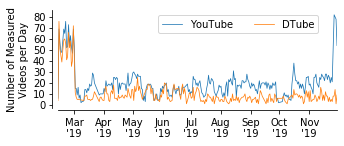

In [45]:
fig, ax = plt.subplots(figsize=(5,2))

youtube_vid_count.set_index('dt')['count'].plot(ax=ax, label='YouTube', linewidth=0.75)
dtube_vid_count.set_index('dt')['count'].plot(ax=ax, label='DTube', linewidth=0.75)

ax.legend(ncol=2, bbox_to_anchor=(0.95,1))

ax.set_yticks(np.arange(0,81,10))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n\'%y'))


ax.grid(False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_position(('axes', -0.02))

ax.set_xlabel('')
ax.set_ylabel('Number of Measured\nVideos per Day')

if save_figures:
    fig.savefig('figures/ts-video-number.pdf', bbox_inches='tight')

In [46]:
cell_vid_count = pd.DataFrame(msm_df[msm_df['network_type'] == 'cellular'
                                    ].groupby(['year', 'month', 'day'], as_index=False
                                            ).size()).reset_index().rename(columns={0 : 'count'})
wifi_vid_count = pd.DataFrame(msm_df[msm_df['network_type'] == 'wifi'
                                    ].groupby(['year', 'month', 'day'], as_index=False
                                                ).size()).reset_index().rename(columns={0 : 'count'})

In [47]:
cell_vid_count['dt'] = pd.to_datetime(cell_vid_count[['year', 'month', 'day']])
wifi_vid_count['dt'] = pd.to_datetime(wifi_vid_count[['year', 'month', 'day']])

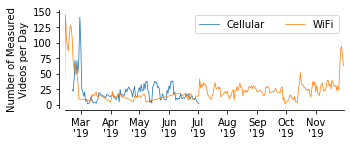

In [48]:
fig, ax = plt.subplots(figsize=(5,2))

cell_vid_count.set_index('dt')['count'].plot(ax=ax, label='Cellular', linewidth=0.75)
wifi_vid_count.set_index('dt')['count'].plot(ax=ax, label='WiFi', linewidth=0.75)

ax.legend(ncol=2)

ax.set_yticks(np.arange(0,151,25))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n\'%y'))


ax.grid(False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_position(('axes', -0.02))

ax.set_xlabel('')
ax.set_ylabel('Number of Measured\nVideos per Day')

if save_figures:
    fig.savefig('figures/ts-video-number-by-network.pdf', bbox_inches='tight')

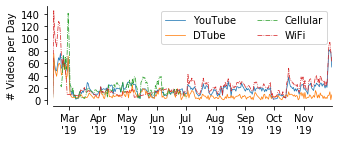

In [110]:
fig, ax = plt.subplots(figsize=(5,2))

youtube_vid_count.set_index('dt')['count'].plot(ax=ax, label='YouTube', linewidth=0.75)
dtube_vid_count.set_index('dt')['count'].plot(ax=ax, label='DTube', linewidth=0.75)
cell_vid_count.set_index('dt')['count'].plot(ax=ax, label='Cellular', linewidth=0.75, linestyle='-.')
wifi_vid_count.set_index('dt')['count'].plot(ax=ax, label='WiFi', linewidth=0.75, linestyle='-.')

ax.legend(ncol=2)

ax.set_yticks(np.arange(0,151,20))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n\'%y'))


ax.grid(False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_position(('axes', -0.02))

ax.set_xlabel('')
ax.set_ylabel('# Videos per Day')

if save_figures:
    fig.savefig('figures/ts-video-number-combined.pdf', bbox_inches='tight')

In [49]:
dtube.groupby(by=['year', 'month'], as_index=False).median()

,year,month,id,time_to_load_web_page_ms,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,video_width,video_height,...,total_played_duration_ms,startup_delay_ms,stall_duration_ms,bandwidth_estimate_bps,initial_exo_processing_time_ms,tcp_connection_time_ms,day,hop_count,id_tr,rttMs
0,2019,2,1.550677e+12,-1.0,1.2855,2.7860,8.471903,60.3980,854.0,480.0,...,59.8950,1.7380,99.5,1.195048,7.0,50.0,20.0,13.0,1.550618e+12,96.0
1,2019,3,1.552454e+12,-1.0,2.7795,2.6880,8.004874,60.4300,854.0,480.0,...,59.9260,3.6285,73.0,1.059918,7.0,50.0,13.0,12.0,1.552721e+12,102.0
2,2019,4,1.555215e+12,-1.0,1.5720,2.6240,9.014915,60.3940,854.0,480.0,...,59.9230,2.4570,74.0,1.452254,8.0,38.0,14.0,12.0,1.555000e+12,80.0
3,2019,5,1.557936e+12,-1.0,1.5260,2.6660,7.512746,60.4045,720.0,480.0,...,59.9245,1.9000,74.0,1.061716,7.0,50.0,15.0,12.0,1.557977e+12,342.0
4,2019,6,1.560614e+12,-1.0,1.0310,2.7330,10.814669,60.3645,854.0,480.0,...,59.9230,1.3355,75.5,1.490496,7.0,39.0,15.0,12.0,1.560741e+12,64.0
5,2019,7,1.562820e+12,-1.0,1.0280,2.7590,9.076450,60.3410,854.0,480.0,...,59.9170,1.3910,81.0,1.329595,6.0,31.0,11.0,12.0,1.562773e+12,56.0
6,2019,8,1.566176e+12,-1.0,1.3630,2.9220,10.029653,60.3670,854.0,480.0,...,59.9150,1.9640,83.0,1.464628,7.0,31.0,19.0,13.0,1.566183e+12,194.0
7,2019,9,1.568360e+12,-1.0,1.4880,3.0880,8.033157,60.3590,854.0,480.0,...,59.8890,2.3440,90.0,1.133014,7.0,33.0,13.0,13.0,1.568365e+12,456.0
8,2019,10,1.571541e+12,-1.0,2.1930,2.8045,8.045716,60.4140,854.0,480.0,...,59.9095,3.1300,87.0,1.275452,7.0,29.0,20.0,14.0,1.571500e+12,196.0
9,2019,11,1.573853e+12,-1.0,2.8400,2.9860,7.021795,60.3620,480.0,480.0,...,59.8960,4.0375,95.5,1.064531,6.0,21.0,15.5,15.0,1.573636e+12,58.0


In [50]:
dtube.columns

Index(['id', 'platform', 'source_url', 'web_url', 'time_to_load_web_page_ms',
       'date_time', 'time_to_reach_source_ms', 'initial_buffer_size_ms',
       'bytes_loaded', 'load_duration_ms', 'video_width', 'video_height',
       'content_duration_ms', 'total_played_duration_ms', 'startup_delay_ms',
       'stall_duration_ms', 'bandwidth_estimate_bps',
       'initial_exo_processing_time_ms', 'tcp_connection_time_ms', 'host',
       'network_type', 'device', 'day', 'month', 'year', 'destination',
       'hop_count', 'id_tr', 'rttMs', 'source', 'provider', 'location'],
      dtype='object')

time_to_reach_source_ms
initial_buffer_size_ms
bytes_loaded
load_duration_ms
video_width
video_height
content_duration_ms
total_played_duration_ms
startup_delay_ms
stall_duration_ms
bandwidth_estimate_bps
initial_exo_processing_time_ms
tcp_connection_time_ms

In [51]:
months = {1: 'January',
          2: 'February',
          3: 'March',
          4: 'April',
          5: 'May',
          6: 'June',
          7: 'July',
          8: 'August',
          9: 'September',
          10: 'October',
          11: 'November',
          12: 'December',
         }

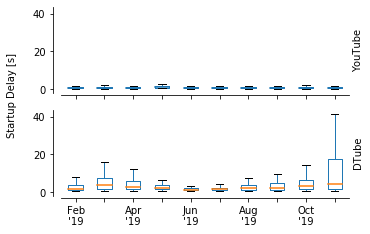

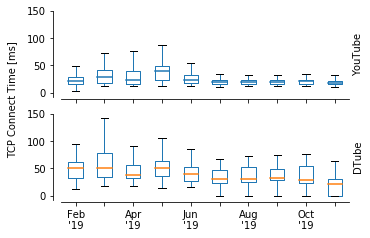

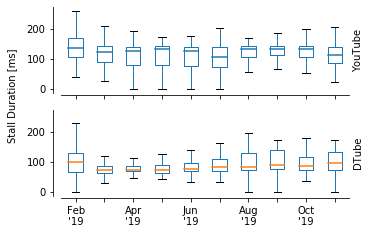

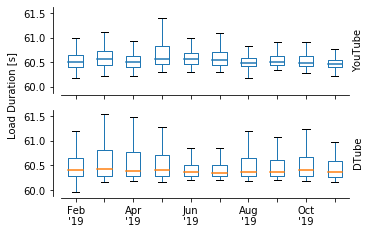

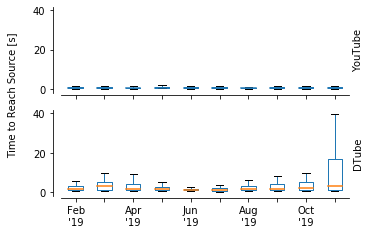

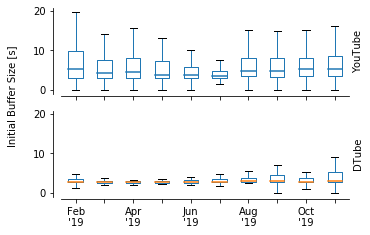

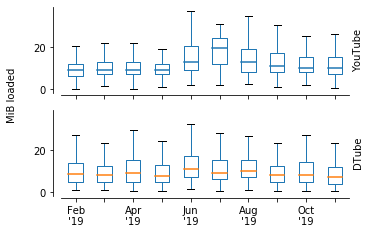

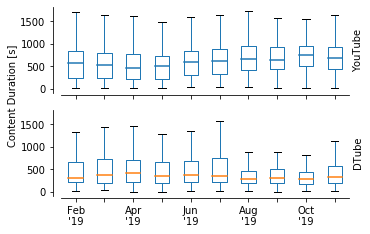

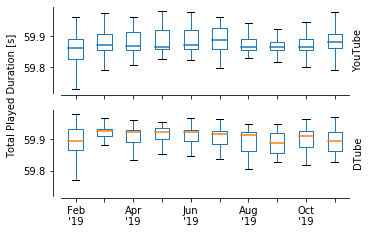

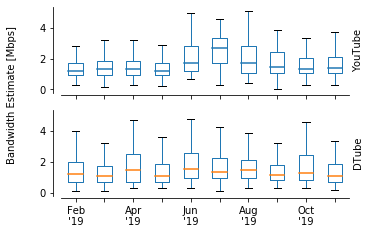

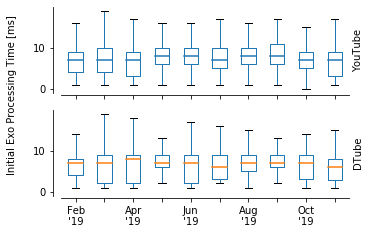

In [52]:
for (metric, col) in info:
    ts_fig, (ts_ax_yt, ts_ax_dt) = plt.subplots(figsize = (5, 3.5), nrows = 2, sharey = True)
    bp_yt = youtube.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_yt, sym = "", 
                    medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')
    bp_dt = dtube.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_dt, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    for (platform, bp) in [('yt', bp_yt), ('dt', bp_dt)]:
        for key in bp.keys():
            for item in bp[key]['medians']:
                if platform == 'yt':
                    item.set_color('C0')
                if platform == 'dt':
                    item.set_color('C1')

    # PLOT FORMATTING
    ts_fig.suptitle('')
    
    for platform, ts_ax in [('YouTube', ts_ax_yt), ('DTube', ts_ax_dt)]:
        ts_ax.set_title('')
        ts_ax.set_xlabel('')

        major_ticklabels = ts_ax.xaxis.get_majorticklabels()
        for ticklabel in major_ticklabels:
            label = ticklabel.get_text()[1:-1]
            y, m = label.split(', ')
            y = y[-2:]
            if int(m) in [2, 4, 6, 8, 10, 12]:
                label = months[int(m)][:3] + '\n\'' + y[-2:] 
            else:
                label = ''
            ticklabel.set_text(label)

        ts_ax.grid(False)
        ts_ax.spines['right'].set_color('none')
        ts_ax.spines['top'].set_color('none')
        ts_ax.yaxis.set_ticks_position('left')
        ts_ax.xaxis.set_ticks_position('bottom')
        ts_ax.spines['bottom'].set_position(('axes', -0.03))
        ts_ax.spines['left'].set_position(('axes', -0.03))

        ts_ax.set_xticklabels(major_ticklabels, rotation = 0)
        
        ax1_ = ts_ax.twinx()
        ax1_.spines['right'].set_color('none')
        ax1_.spines['top'].set_color('none')
        ax1_.spines['left'].set_color('none')
        ax1_.spines['bottom'].set_color('none')
        ax1_.yaxis.set_ticks_position('none')
        ax1_.set_ylabel('%s' % platform)
        plt.setp(ax1_.get_yticklabels(), visible = False)
    
    ts_ax_yt.set_xticklabels('')
    
    ts_fig.text(-0.05, 0.55, '%s' % metric, va='center', rotation='vertical')

    if save_figures:
        ts_fig.savefig('figures/time-boxes/%s.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), 
                       bbox_inches = 'tight')
    plt.show()

plt.close('all')

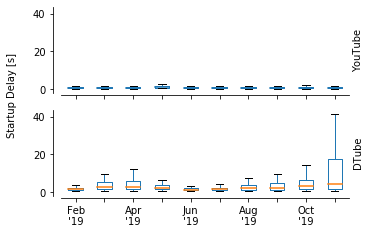

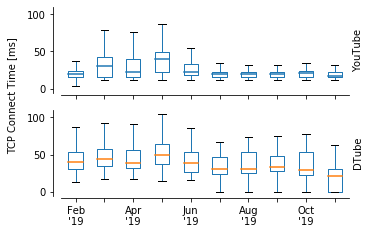

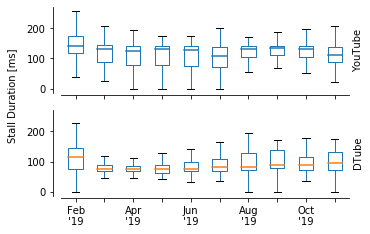

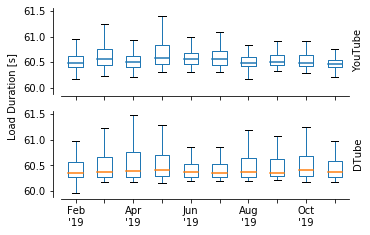

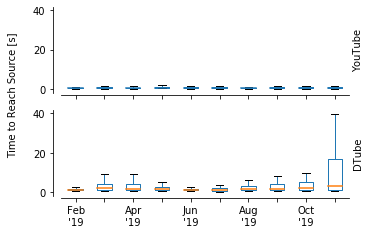

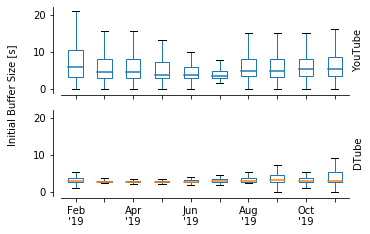

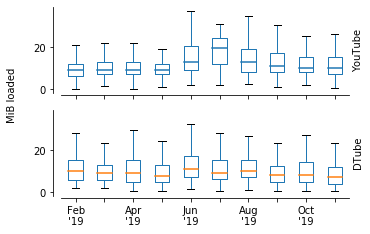

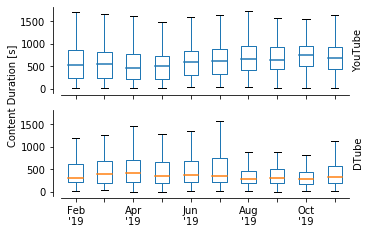

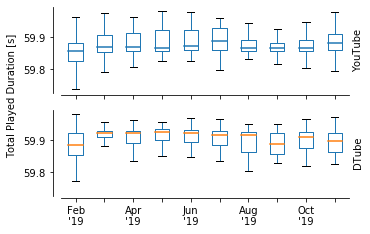

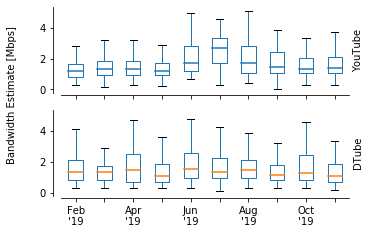

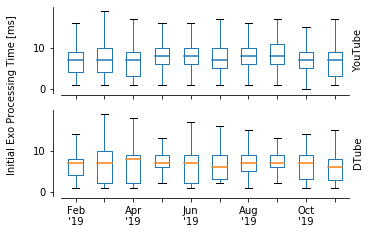

In [53]:
for (metric, col) in info:
    ts_fig, (ts_ax_yt, ts_ax_dt) = plt.subplots(figsize = (5, 3.5), nrows = 2, sharey = True)
    bp_yt = youtube_eu.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_yt, sym = "", 
                    medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')
    bp_dt = dtube_eu.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_dt, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    for (platform, bp) in [('yt', bp_yt), ('dt', bp_dt)]:
        for key in bp.keys():
            for item in bp[key]['medians']:
                if platform == 'yt':
                    item.set_color('C0')
                if platform == 'dt':
                    item.set_color('C1')

    # PLOT FORMATTING
    ts_fig.suptitle('')
    
    for platform, ts_ax in [('YouTube', ts_ax_yt), ('DTube', ts_ax_dt)]:
        ts_ax.set_title('')
        ts_ax.set_xlabel('')

        major_ticklabels = ts_ax.xaxis.get_majorticklabels()
        for ticklabel in major_ticklabels:
            label = ticklabel.get_text()[1:-1]
            y, m = label.split(', ')
            y = y[-2:]
            if int(m) in [2, 4, 6, 8, 10, 12]:
                label = months[int(m)][:3] + '\n\'' + y[-2:] 
            else:
                label = ''
            ticklabel.set_text(label)

        ts_ax.grid(False)
        ts_ax.spines['right'].set_color('none')
        ts_ax.spines['top'].set_color('none')
        ts_ax.yaxis.set_ticks_position('left')
        ts_ax.xaxis.set_ticks_position('bottom')
        ts_ax.spines['bottom'].set_position(('axes', -0.03))
        ts_ax.spines['left'].set_position(('axes', -0.03))

        ts_ax.set_xticklabels(major_ticklabels, rotation = 0)
        
        ax1_ = ts_ax.twinx()
        ax1_.spines['right'].set_color('none')
        ax1_.spines['top'].set_color('none')
        ax1_.spines['left'].set_color('none')
        ax1_.spines['bottom'].set_color('none')
        ax1_.yaxis.set_ticks_position('none')
        ax1_.set_ylabel('%s' % platform)
        plt.setp(ax1_.get_yticklabels(), visible = False)
    
    ts_ax_yt.set_xticklabels('')
    
    ts_fig.text(-0.05, 0.55, '%s' % metric, va='center', rotation='vertical')

    if save_figures:
        ts_fig.savefig('figures/time-boxes/eu-only/%s.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), 
                       bbox_inches = 'tight')
    plt.show()

plt.close('all')

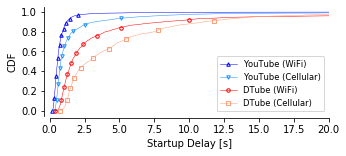

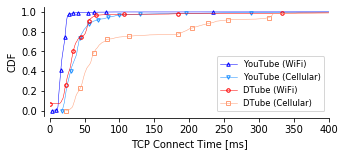

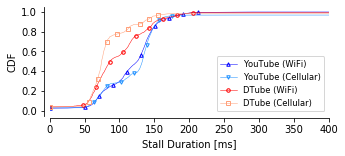

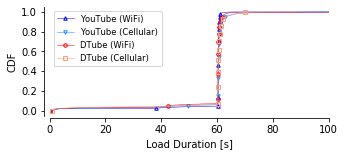

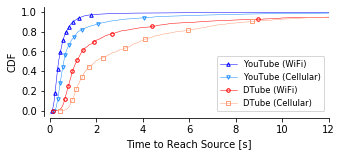

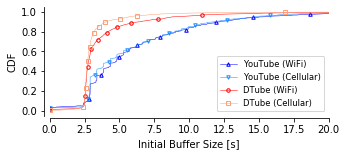

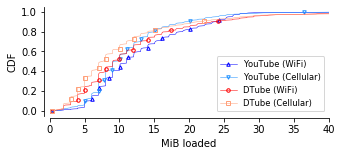

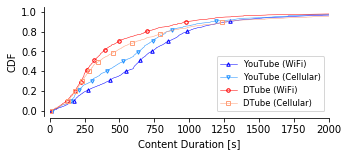

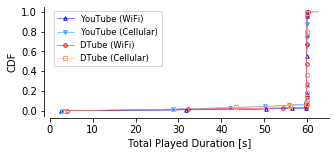

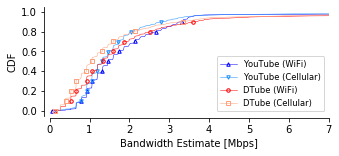

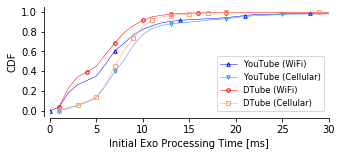

In [54]:
markers = ['^',
           'v',
           'o',
           's']
colors = ['blue',
          'dodgerblue',
          'red',
          'lightsalmon']
labels = ['YouTube (WiFi)',
          'YouTube (Cellular)',
          'DTube (WiFi)',
          'DTube (Cellular)']

lims = {
    'startup_delay_ms' : (20),
    'tcp_connection_time_ms' : (400),
    'stall_duration_ms' : (400),
    'load_duration_ms' : (100),
    'time_to_reach_source_ms' : (12),
    'initial_buffer_size_ms' : (20),
    'bytes_loaded' : (40),
    'content_duration_ms' : (2000),
    'total_played_duration_ms' : (65),
    'bandwidth_estimate_bps' : (7),
    'initial_exo_processing_time_ms' : (30),
}

log_scales = ['load_duration_ms', 'bytes_loaded', 'content_duration_ms', 'total_played_duration_ms']

for (metric, col) in info:
    
    dtube_wifi = Cdf.MakeCdfFromList(dtube[dtube['network_type'] == 'wifi'][col])
    dtube_cell = Cdf.MakeCdfFromList(dtube[dtube['network_type'] == 'cellular'][col])

    youtube_wifi = Cdf.MakeCdfFromList(youtube[youtube['network_type'] == 'wifi'][col])
    youtube_cell = Cdf.MakeCdfFromList(youtube[youtube['network_type'] == 'cellular'][col])

    cdfs = [youtube_wifi, youtube_cell, dtube_wifi, dtube_cell]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(4):
        ax.plot(cdfs[i].xs, cdfs[i].ps, 
                label = '%s' % (labels[i]), 
                marker = markers[i], 
                linewidth = 0.5, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = colors[i],
                markevery=max(1, int(len(cdfs[i].xs)/10))
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], metric.split(' [')[0].replace(' ', '-').lower(), metric, labels[i])
        
    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_xlim([0, lims[col]])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc = 'best', fontsize = 'small')

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    
    if save_figures:
        fig.savefig('figures/cdfs/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), bbox_inches = 'tight')

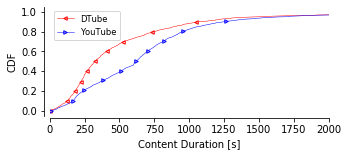

In [55]:
dtube_cdf = Cdf.MakeCdfFromList(dtube['content_duration_ms'])
youtube_cdf = Cdf.MakeCdfFromList(youtube['content_duration_ms'])

fig, ax = plt.subplots(figsize=(5,2))

ax.plot(dtube_cdf.xs, dtube_cdf.ps, 
        label = 'DTube', 
        marker = '<', 
        linewidth = 0.5, 
        markersize = 3.5, 
        fillstyle = 'none', 
        color = 'red',
        markevery=max(1, int(len(dtube_cdf.xs)/10))
       )

ax.plot(youtube_cdf.xs, youtube_cdf.ps, 
        label = 'YouTube', 
        marker = '>', 
        linewidth = 0.5, 
        markersize = 3.5, 
        fillstyle = 'none', 
        color = 'blue',
        markevery=max(1, int(len(youtube_cdf.xs)/10))
       )

if export_cdf:
    export_cdf_dist(dtube_cdf, 'content-duration-dtube', 'content-duration-ms', 'DTube Content Duration')
    export_cdf_dist(youtube_cdf, 'content-duration-youtube', 'content-duration-ms', 'YouTube Content Duration')
    
# PLOT FORMATTING
ax.set_xlabel('Content Duration [s]')
ax.set_ylabel('CDF')
ax.set_xlim([0, 2000])
ax.set_ylim([-0.05, 1.05])
ax.legend(loc = 'best', fontsize = 'small')

yticks = np.arange(0.0, 1.01, 0.2)
ax.set_yticks(yticks)
ax.grid(False)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.02))
ax.spines['left'].set_position(('axes', -0.02))

if save_figures:
    fig.savefig('figures/cdfs/content-duration-by-platform-cdf.pdf', bbox_inches = 'tight')

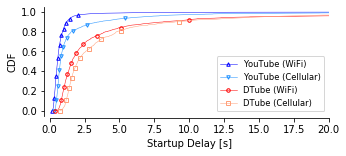

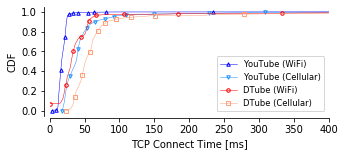

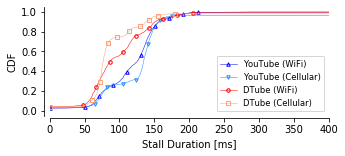

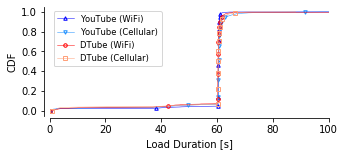

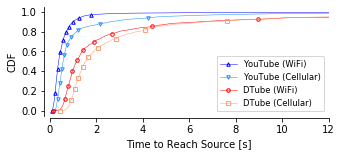

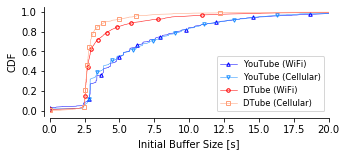

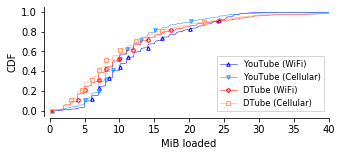

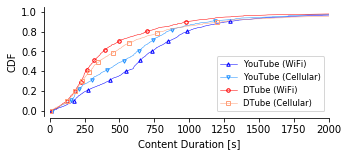

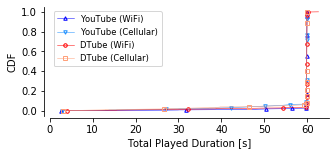

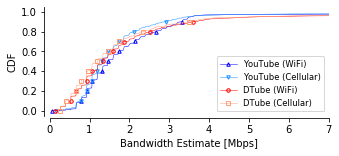

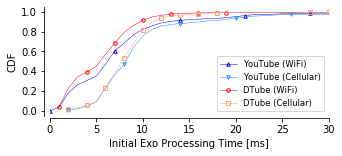

In [56]:
for (metric, col) in info:
    
    dtube_wifi = Cdf.MakeCdfFromList(dtube_eu[dtube_eu['network_type'] == 'wifi'][col])
    dtube_cell = Cdf.MakeCdfFromList(dtube_eu[dtube_eu['network_type'] == 'cellular'][col])

    youtube_wifi = Cdf.MakeCdfFromList(youtube_eu[youtube_eu['network_type'] == 'wifi'][col])
    youtube_cell = Cdf.MakeCdfFromList(youtube_eu[youtube_eu['network_type'] == 'cellular'][col])

    cdfs = [youtube_wifi, youtube_cell, dtube_wifi, dtube_cell]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(4):
        ax.plot(cdfs[i].xs, cdfs[i].ps, 
                label = '%s' % (labels[i]), 
                marker = markers[i], 
                linewidth = 0.5, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = colors[i],
                markevery=max(1, int(len(cdfs[i].xs)/10))
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], 'eu-only/' + metric.split(' [')[0].replace(' ', '-').lower(), metric, labels[i])
        

    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_xlim([0, lims[col]])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc = 'best', fontsize = 'small')

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    
    if save_figures:
        fig.savefig('figures/cdfs/eu-only/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(),
                    bbox_inches = 'tight')

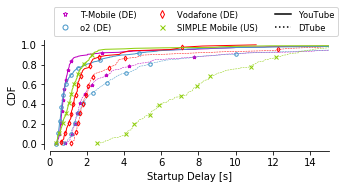

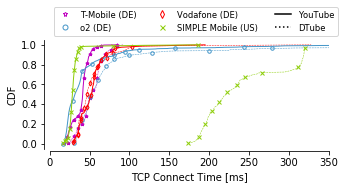

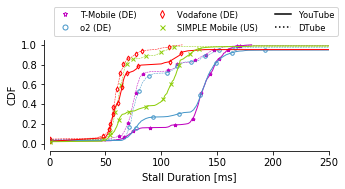

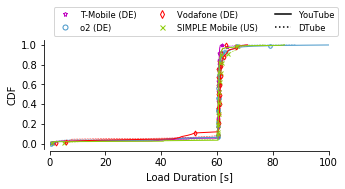

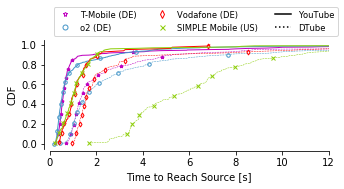

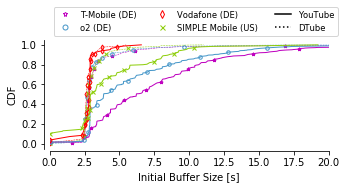

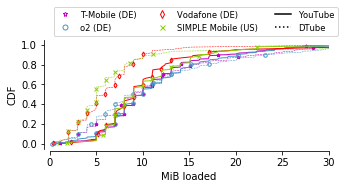

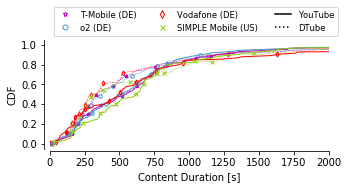

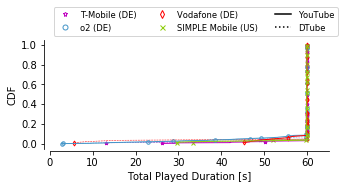

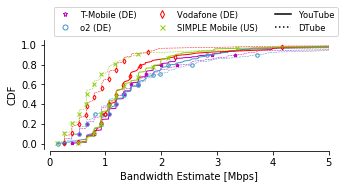

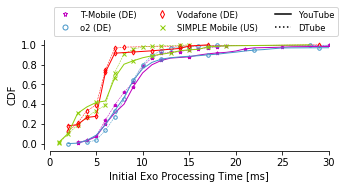

In [57]:
prov_markers = ['*',
                'o',
                'd',
                'x']
prov_colors = ['m',
               '#4697c9',
               'red',
               '#8ece0b']
prov_labels = ['T-Mobile (DE)',
               'o2 (DE)',
               'Vodafone (DE)',
               'SIMPLE Mobile (US)']

custom_handles = []
for i in range(4):
    tmp = mlines.Line2D([], [], color=prov_colors[i], marker=prov_markers[i],
                        markersize=5, label=prov_labels[i], linestyle='none', fillstyle='none')
    custom_handles.append(tmp)

custom_handles.append(mlines.Line2D([], [], label='YouTube', color='black', linestyle='-', fillstyle='none'))
custom_handles.append(mlines.Line2D([], [], label='DTube', color='black', linestyle=':', fillstyle='none'))
    
prov_lims = {
    'startup_delay_ms' : (15),
    'tcp_connection_time_ms' : (350),
    'stall_duration_ms' : (250),
    'load_duration_ms' : (100),
    'time_to_reach_source_ms' : (12),
    'initial_buffer_size_ms' : (20),
    'bytes_loaded' : (30),
    'content_duration_ms' : (2000),
    'total_played_duration_ms' : (65),
    'bandwidth_estimate_bps' : (5),
    'initial_exo_processing_time_ms' : (30),
}
    
    
for (metric, col) in info:
    
    dtube_tm = Cdf.MakeCdfFromList(dtube[dtube['provider'] == 'T-Mobile (DE)'][col])
    dtube_o2 = Cdf.MakeCdfFromList(dtube[dtube['provider'] == 'o2 (DE)'][col])
    dtube_vf = Cdf.MakeCdfFromList(dtube[dtube['provider'] == 'Vodafone (DE)'][col])
    dtube_sm = Cdf.MakeCdfFromList(dtube[dtube['provider'] == 'SIMPLE Mobile (US)'][col])
    
    youtube_tm = Cdf.MakeCdfFromList(youtube[youtube['provider'] == 'T-Mobile (DE)'][col])
    youtube_o2 = Cdf.MakeCdfFromList(youtube[youtube['provider'] == 'o2 (DE)'][col])
    youtube_vf = Cdf.MakeCdfFromList(youtube[youtube['provider'] == 'Vodafone (DE)'][col])
    youtube_sm = Cdf.MakeCdfFromList(youtube[youtube['provider'] == 'SIMPLE Mobile (US)'][col])

    cdfs = [dtube_tm,
            dtube_o2,
            dtube_vf,
            dtube_sm,
            youtube_tm,
            youtube_o2,
            youtube_vf,
            youtube_sm
           ]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(8):
        ax.plot(cdfs[i].xs, cdfs[i].ps,
                marker = prov_markers[i%4], 
                linewidth = 0.5 if i<4 else 1, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = prov_colors[i%4],
                markevery=max(1, int(len(cdfs[i].xs)/10)),
                linestyle = '--' if i<4 else '-'
               )

        if export_cdf:
            export_cdf_dist(cdfs[i], 'by-providers/' + metric.split(' [')[0].replace(' ', '-').lower(),
                            metric, '%s + %s' % ('DTube' if i<4 else 'YouTube', prov_labels[i%4]))
        
        
    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_xlim([0, prov_lims[col]])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(handles=custom_handles, loc = 'lower left', fontsize = 'small', ncol=3, bbox_to_anchor=(0,1))

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))

    if save_figures:
        fig.savefig('figures/providers/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), bbox_inches = 'tight')

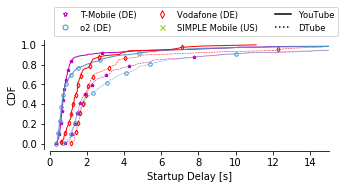

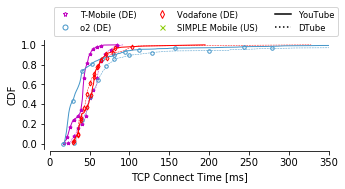

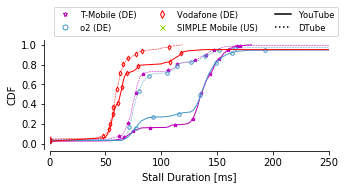

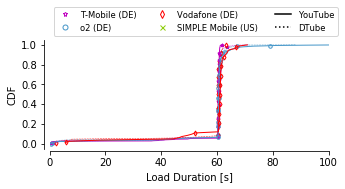

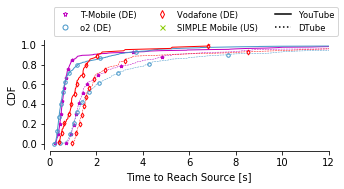

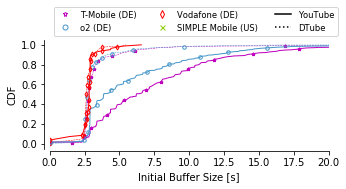

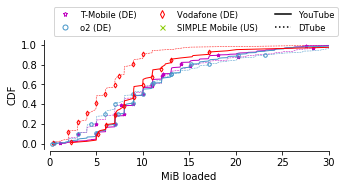

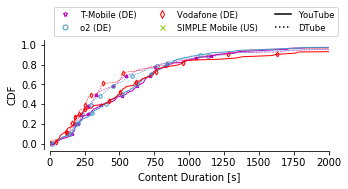

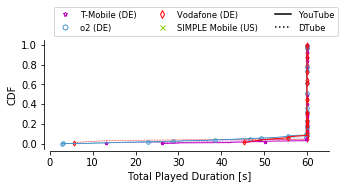

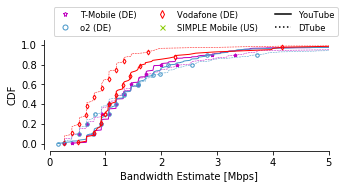

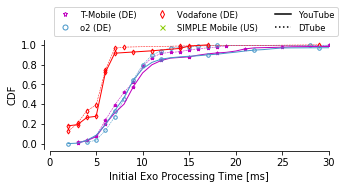

In [58]:
for (metric, col) in info:
    
    dtube_tm = Cdf.MakeCdfFromList(dtube_eu[dtube_eu['provider'] == 'T-Mobile (DE)'][col])
    dtube_o2 = Cdf.MakeCdfFromList(dtube_eu[dtube_eu['provider'] == 'o2 (DE)'][col])
    dtube_vf = Cdf.MakeCdfFromList(dtube_eu[dtube_eu['provider'] == 'Vodafone (DE)'][col])
    dtube_sm = Cdf.MakeCdfFromList(dtube_eu[dtube_eu['provider'] == 'SIMPLE Mobile (US)'][col])
    
    youtube_tm = Cdf.MakeCdfFromList(youtube_eu[youtube_eu['provider'] == 'T-Mobile (DE)'][col])
    youtube_o2 = Cdf.MakeCdfFromList(youtube_eu[youtube_eu['provider'] == 'o2 (DE)'][col])
    youtube_vf = Cdf.MakeCdfFromList(youtube_eu[youtube_eu['provider'] == 'Vodafone (DE)'][col])
    youtube_sm = Cdf.MakeCdfFromList(youtube_eu[youtube_eu['provider'] == 'SIMPLE Mobile (US)'][col])

    cdfs = [dtube_tm,
            dtube_o2,
            dtube_vf,
            dtube_sm,
            youtube_tm,
            youtube_o2,
            youtube_vf,
            youtube_sm
           ]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(8):
        ax.plot(cdfs[i].xs, cdfs[i].ps,
                marker = prov_markers[i%4], 
                linewidth = 0.5 if i<4 else 1, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = prov_colors[i%4],
                markevery=max(1, int(len(cdfs[i].xs)/10)),
                linestyle = '--' if i<4 else '-'
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], 'by-providers/eu-only/' + metric.split(' [')[0].replace(' ', '-').lower(),
                            metric, '%s + %s' % ('DTube' if i<4 else 'YouTube', prov_labels[i%4]), )
        

    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_xlim([0, prov_lims[col]])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(handles=custom_handles, loc = 'lower left', fontsize = 'small', ncol=3, bbox_to_anchor=(0,1))

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))

    if save_figures:
        fig.savefig('figures/providers/eu-only/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(),
                    bbox_inches = 'tight')

In [59]:
msm_df[msm_df['content_duration_ms'] > 70][
    ['total_played_duration_ms', 'content_duration_ms', 'bytes_loaded', 'load_duration_ms', 'bandwidth_estimate_bps']
].tail()

,total_played_duration_ms,content_duration_ms,bytes_loaded,load_duration_ms,bandwidth_estimate_bps
8545,59.853,416.728,4.000915,60.492,0.529116
8546,59.863,1537.091,12.071542,60.474,1.596923
8547,59.868,187.339,7.032560,60.439,0.930863
8548,59.912,262.219,53.603714,60.691,7.065787
8549,59.828,238.550,7.006043,60.296,0.929553


In [60]:
msm_df[msm_df['content_duration_ms'] < 40][
    ['total_played_duration_ms', 'content_duration_ms', 'bytes_loaded', 'load_duration_ms', 'bandwidth_estimate_bps']
].tail()

,total_played_duration_ms,content_duration_ms,bytes_loaded,load_duration_ms,bandwidth_estimate_bps
8349,27.105,27.097,1.427553,0.651,38.452610
8364,26.775,26.775,0.835413,1.381,17.347016
8393,31.860,31.857,7.628280,1.329,52.974164
8525,12.058,12.051,0.419683,0.759,37.724355
8550,20.884,20.880,1.493686,9.749,7.881062


Calculation seems to be correct for videos that are not longer than 60ish seconds, longer videos automatically set the load_duration to 60ish seconds?

# Traceroute

### IP to ASN

In [61]:
ip_asn_map = pd.DataFrame(pd.Series(msm_df['destination'].unique()).dropna().sort_values(),
                          columns=['ip'])
ip_asn_map.to_csv('unique-destinations.csv')

In [62]:
asndb = pyasn.pyasn('ipasn.dat')
def lookup_asn(ip):
    asn, prefix = asndb.lookup(ip)
    return asn

ip_asn_map['asn'] = ip_asn_map['ip'].map(lookup_asn)

In [63]:
ip_asn_map

,ip,asn
33,147.135.137.129,16276
5,149.202.203.13,16276
12,149.202.220.135,16276
70,172.217.130.10,15169
56,172.217.130.38,15169
46,172.217.130.39,15169
101,172.217.130.40,15169
41,172.217.130.41,15169
94,172.217.130.42,15169
53,172.217.130.6,15169


In [64]:
with open('asnames.json') as f:
    as_names_dict = json.load(f)

In [65]:
as_names_df = pd.DataFrame.from_dict(as_names_dict, orient='index').reset_index(level=0)
as_names_df.rename(columns={'index' : 'asn', 0: 'as_holder'}, inplace=True)
as_names_df['asn'] = as_names_df['asn'].astype(int)

In [66]:
as_names_df.head()

,asn,as_holder
0,0,"-Reserved AS-, ZZ"
1,1,"LVLT-1 - Level 3 Parent, LLC, US"
2,2,"UDEL-DCN - University of Delaware, US"
3,3,MIT-GATEWAYS - Massachusetts Institute of Tech...
4,4,"ISI-AS - University of Southern California, US"


In [67]:
len(msm_df)

8551

In [68]:
ip_asn_map = ip_asn_map.merge(as_names_df, how='left', on='asn')

In [69]:
msm_df = msm_df.merge(ip_asn_map, how='left', left_on='destination', right_on='ip')
msm_df.drop(columns='ip', inplace=True)

In [70]:
len(msm_df)

8551

In [71]:
msm_df.groupby(['asn', 'as_holder']).size().sort_values(ascending=False)

asn      as_holder                                
15169.0  GOOGLE - Google LLC, US                      4546
16276.0  OVH, FR                                      2193
5610.0   O2-CZECH-REPUBLIC, CZ                         196
21928.0  T-MOBILE-AS21928 - T-Mobile USA, Inc., US     105
6805.0   TDDE-ASN1, DE                                  35
8767.0   MNET-AS Germany, DE                             3
dtype: int64

### Split YouTube and DTube

In [72]:
yt_tr = msm_df[(msm_df['platform'] == 'youtube') 
               & (msm_df['hop_count'] > 0)
               & (msm_df['rttMs'] <= 5000)]

dt_tr = msm_df[(msm_df['platform'] == 'dtube')
               & (msm_df['hop_count'] > 0)
               & (msm_df['rttMs'] <= 5000)]

In [73]:
yt_tr

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,year,destination,hop_count,id_tr,rttMs,source,provider,location,asn,as_holder
0,1550479750086,youtube,https://r2---sn-4g5e6nzz.googlevideo.com/video...,https://www.youtube.com/watch?v=MqmLwcDwPFI,-1,2019-02-18 09:00:00,0.769,11.795,9.009181,60.625,...,2019,74.125.173.199,10.0,1.550480e+12,28.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
1,1550479817275,youtube,https://r1---sn-4g5e6nes.googlevideo.com/video...,https://www.youtube.com/watch?v=xyvWm6V6FgI,-1,2019-02-18 09:00:00,0.499,10.402,9.016939,60.400,...,2019,173.194.151.71,10.0,1.550481e+12,28.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
2,1550479885346,youtube,https://r3---sn-4g5ednle.googlevideo.com/video...,https://www.youtube.com/watch?v=mJH8st5qAz8,-1,2019-02-18 09:00:00,0.522,8.544,12.035786,60.369,...,2019,74.125.104.89,10.0,1.550481e+12,26.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
3,1550479951556,youtube,https://r2---sn-4g5e6nsd.googlevideo.com/video...,https://www.youtube.com/watch?v=GErzE-plSok,-1,2019-02-18 09:00:00,0.736,5.758,10.055004,60.656,...,2019,173.194.187.39,10.0,1.550481e+12,26.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
4,1550480018975,youtube,https://r2---sn-4g5edney.googlevideo.com/video...,https://www.youtube.com/watch?v=LGW1VhrHsbA,-1,2019-02-18 09:00:00,0.456,21.083,5.012936,60.351,...,2019,173.194.165.168,10.0,1.550481e+12,26.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
10,1550508566226,youtube,https://r6---sn-4g5edne6.googlevideo.com/video...,https://www.youtube.com/watch?v=Lqk8TDuXtcg,-1,2019-02-18 17:00:00,0.611,3.390,23.296008,60.755,...,2019,173.194.164.156,10.0,1.550509e+12,24.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
11,1550508632756,youtube,https://r6---sn-4g5ednll.googlevideo.com/video...,https://www.youtube.com/watch?v=l6-_EokklYk,-1,2019-02-18 17:00:00,0.379,4.365,16.101657,60.549,...,2019,74.125.173.60,10.0,1.550509e+12,38.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
12,1550508698856,youtube,https://r2---sn-4g5e6nsr.googlevideo.com/video...,https://www.youtube.com/watch?v=CvqvxT3M1Nw,-1,2019-02-18 17:00:00,0.290,3.320,24.136039,60.407,...,2019,173.194.187.103,10.0,1.550510e+12,830.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
13,1550508764777,youtube,https://r6---sn-4g5e6nlk.googlevideo.com/video...,https://www.youtube.com/watch?v=arwNsHIPre4,-1,2019-02-18 17:00:00,0.621,2.902,13.044702,60.717,...,2019,74.125.173.44,10.0,1.550510e+12,666.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"
14,1550508831204,youtube,https://r5---sn-4g5ednss.googlevideo.com/video...,https://www.youtube.com/watch?v=xgHHUNYmDGw,-1,2019-02-18 17:00:00,0.770,9.473,5.007527,60.765,...,2019,173.194.188.106,10.0,1.550510e+12,44.0,172.24.21.219,-,DE,15169.0,"GOOGLE - Google LLC, US"


In [74]:
dt_tr

,id,platform,source_url,web_url,time_to_load_web_page_ms,date_time,time_to_reach_source_ms,initial_buffer_size_ms,bytes_loaded,load_duration_ms,...,year,destination,hop_count,id_tr,rttMs,source,provider,location,asn,as_holder
5,1550480086369,dtube,https://video.dtube.top/ipfs/QmRczgVbRwxyhQ9Sy...,https://d.tube/#!/v/coolguy222/c82262xv,-1,2019-02-18 09:00:00,3.593,2.502,14.039023,62.124,...,2019,149.202.203.13,11.0,1.550481e+12,672.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
6,1550480158459,dtube,https://video.dtube.top/ipfs/Qmbwmkye725JB1zVC...,https://d.tube/#!/v/broncnutz/eqtwu2ye,-1,2019-02-18 09:00:00,1.201,3.413,11.034425,60.334,...,2019,149.202.203.13,11.0,1.550481e+12,656.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
7,1550480225632,dtube,https://video.dtube.top/ipfs/QmYq3mLoDtVbaG5aU...,https://d.tube/#!/v/priyanarc/2k0v5kbn,-1,2019-02-18 09:00:00,5.217,2.623,38.279714,62.011,...,2019,149.202.203.13,11.0,1.550481e+12,3988.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
8,1550480298849,dtube,https://video.dtube.top/ipfs/QmcrbQa9cm7p3EAqH...,https://d.tube/#!/v/travelgirl/0gxjqhhw,-1,2019-02-18 09:00:00,3.682,2.581,20.090528,61.056,...,2019,149.202.203.13,11.0,1.550481e+12,1720.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
9,1550480368998,dtube,https://video.dtube.top/ipfs/QmYsVVW9sWZc13zxG...,https://d.tube/#!/v/pennsif/nfz365i0,-1,2019-02-18 09:00:00,10.573,8.405,2.014374,60.699,...,2019,149.202.203.13,11.0,1.550481e+12,2654.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
15,1550508897682,dtube,https://video.dtube.top/ipfs/Qme8sTJojzqvqWsNH...,https://d.tube/#!/v/evecab/ir4js9vf,-1,2019-02-18 17:00:00,2.232,2.560,8.010933,60.670,...,2019,46.105.111.199,12.0,1.550511e+12,628.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
16,1550508966069,dtube,https://video.dtube.top/ipfs/QmfCk1WeNapG4xKbs...,https://d.tube/#!/v/livinguktaiwan/5zqcx98i,-1,2019-02-18 17:00:00,2.759,2.656,16.195715,61.498,...,2019,46.105.111.199,12.0,1.550511e+12,738.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
17,1550509035799,dtube,https://video.dtube.top/ipfs/QmctWtvu2A6V2sAkL...,https://d.tube/#!/v/coruscate/zd5goftn,-1,2019-02-18 17:00:00,1.694,2.647,7.017683,60.591,...,2019,149.202.220.135,11.0,1.550511e+12,772.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
18,1550509103407,dtube,https://video.dtube.top/ipfs/QmZEfyxB12oEhizJZ...,https://d.tube/#!/v/thecrytotrader/4k8jzkbn,-1,2019-02-18 17:00:00,1.980,2.879,4.008736,60.530,...,2019,149.202.220.135,11.0,1.550512e+12,900.0,172.24.21.219,-,DE,16276.0,"OVH, FR"
19,1550509171358,dtube,https://video.dtube.top/ipfs/QmWuVfHMQqGNwVoYU...,https://d.tube/#!/v/theycallmedan/otknzijt,-1,2019-02-18 17:00:00,1.433,5.944,2.020609,60.283,...,2019,46.105.111.199,12.0,1.550512e+12,200.0,172.24.21.219,-,DE,16276.0,"OVH, FR"


In [75]:
yt_tr_eu = yt_tr[yt_tr['location'] != 'US']
dt_tr_eu = dt_tr[dt_tr['location'] != 'US']

In [76]:
pd.crosstab(yt_tr['network_type'], yt_tr['as_holder'] + ' (ASN' + yt_tr['asn'].astype(int).map(str) + ')',
            margins=True
           )

col_0,"GOOGLE - Google LLC, US (ASN15169)","MNET-AS Germany, DE (ASN8767)","O2-CZECH-REPUBLIC, CZ (ASN5610)","T-MOBILE-AS21928 - T-Mobile USA, Inc., US (ASN21928)","TDDE-ASN1, DE (ASN6805)",All
network_type,,,,,,
cellular,921,0,0,105,35,1061
wifi,3623,3,196,0,0,3822
All,4544,3,196,105,35,4883


In [77]:
print(_.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
col\_0 &  GOOGLE - Google LLC, US (ASN15169) &  MNET-AS Germany, DE (ASN8767) &  O2-CZECH-REPUBLIC, CZ (ASN5610) &  T-MOBILE-AS21928 - T-Mobile USA, Inc., US (ASN21928) &  TDDE-ASN1, DE (ASN6805) &   All \\
network\_type &                                     &                                &                                  &                                                       &                          &       \\
\midrule
cellular     &                                 921 &                              0 &                                0 &                                                105 &                       35 &  1061 \\
wifi         &                                3623 &                              3 &                              196 &                                                  0 &                        0 &  3822 \\
All          &                                4544 &                              3 &                              1

In [78]:
pd.crosstab(yt_tr['network_type'], yt_tr['as_holder'] + ' (ASN' + yt_tr['asn'].astype(int).map(str) + ')',
            margins=True, normalize=True
           ).round(3)

col_0,"GOOGLE - Google LLC, US (ASN15169)","MNET-AS Germany, DE (ASN8767)","O2-CZECH-REPUBLIC, CZ (ASN5610)","T-MOBILE-AS21928 - T-Mobile USA, Inc., US (ASN21928)","TDDE-ASN1, DE (ASN6805)",All
network_type,,,,,,
cellular,0.189,0.000,0.00,0.022,0.007,0.217
wifi,0.742,0.001,0.04,0.000,0.000,0.783
All,0.931,0.001,0.04,0.022,0.007,1.000


In [79]:
print(_.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
col\_0 &  GOOGLE - Google LLC, US (ASN15169) &  MNET-AS Germany, DE (ASN8767) &  O2-CZECH-REPUBLIC, CZ (ASN5610) &  T-MOBILE-AS21928 - T-Mobile USA, Inc., US (ASN21928) &  TDDE-ASN1, DE (ASN6805) &    All \\
network\_type &                                     &                                &                                  &                                                       &                          &        \\
\midrule
cellular     &                               0.189 &                          0.000 &                             0.00 &                                              0.022 &                    0.007 &  0.217 \\
wifi         &                               0.742 &                          0.001 &                             0.04 &                                              0.000 &                    0.000 &  0.783 \\
All          &                               0.931 &                          0.001 &                           

In [80]:
pd.crosstab(dt_tr['network_type'], dt_tr['as_holder'] + ' (ASN' + dt_tr['asn'].astype(int).map(str) + ')',
            margins=True
           )

col_0,"OVH, FR (ASN16276)",All
network_type,,
cellular,634,634
wifi,1556,1556
All,2190,2190


In [81]:
print(_.to_latex())

\begin{tabular}{lrr}
\toprule
col\_0 &  OVH, FR (ASN16276) &   All \\
network\_type &                     &       \\
\midrule
cellular     &                 634 &   634 \\
wifi         &                1556 &  1556 \\
All          &                2190 &  2190 \\
\bottomrule
\end{tabular}



In [82]:
pd.crosstab(dt_tr['network_type'], dt_tr['as_holder'] + ' (ASN' + dt_tr['asn'].astype(int).map(str) + ')',
            margins=True, normalize=True
           ).round(3)

col_0,"OVH, FR (ASN16276)",All
network_type,,
cellular,0.289,0.289
wifi,0.711,0.711
All,1.000,1.000


In [83]:
print(_.to_latex())

\begin{tabular}{lrr}
\toprule
col\_0 &  OVH, FR (ASN16276) &    All \\
network\_type &                     &        \\
\midrule
cellular     &               0.289 &  0.289 \\
wifi         &               0.711 &  0.711 \\
All          &               1.000 &  1.000 \\
\bottomrule
\end{tabular}



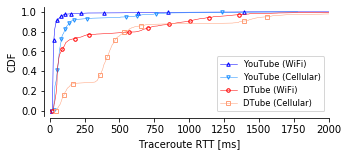

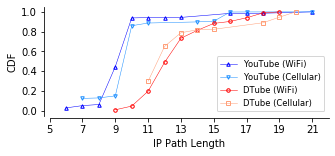

In [84]:
for (metric, col) in [('Traceroute RTT [ms]', 'rttMs'), ('IP Path Length', 'hop_count')]:
    
    dtube_wifi = Cdf.MakeCdfFromList(dt_tr[dt_tr['network_type'] == 'wifi'][col])
    dtube_cell = Cdf.MakeCdfFromList(dt_tr[dt_tr['network_type'] == 'cellular'][col])

    youtube_wifi = Cdf.MakeCdfFromList(yt_tr[yt_tr['network_type'] == 'wifi'][col])
    youtube_cell = Cdf.MakeCdfFromList(yt_tr[yt_tr['network_type'] == 'cellular'][col])

    cdfs = [youtube_wifi, youtube_cell, dtube_wifi, dtube_cell]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(4):
        ax.plot(cdfs[i].xs, cdfs[i].ps, 
                label = '%s' % (labels[i]), 
                marker = markers[i], 
                linewidth = 0.5, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = colors[i],
                markevery=max(1, int(len(cdfs[i].xs)/10))
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], metric.split(' [')[0].replace(' ', '-').lower(), metric, labels[i])
        

    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    
    if 'Path' in metric:
        ax.set_xlim([5, 22])
        ax.set_xticks(np.arange(5,23,2))
    elif 'RTT' in metric:
        ax.set_xlim([0, 2000])
    
    ax.legend(loc = 'best', fontsize = 'small')

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    
    if save_figures:
        fig.savefig('figures/cdfs/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), bbox_inches = 'tight')

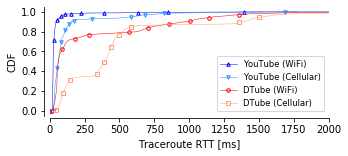

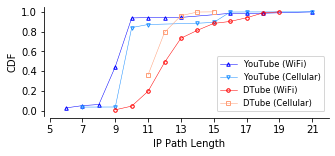

In [85]:
for (metric, col) in [('Traceroute RTT [ms]', 'rttMs'), ('IP Path Length', 'hop_count')]:
    
    dtube_wifi = Cdf.MakeCdfFromList(dt_tr_eu[dt_tr_eu['network_type'] == 'wifi'][col])
    dtube_cell = Cdf.MakeCdfFromList(dt_tr_eu[dt_tr_eu['network_type'] == 'cellular'][col])

    youtube_wifi = Cdf.MakeCdfFromList(yt_tr_eu[yt_tr_eu['network_type'] == 'wifi'][col])
    youtube_cell = Cdf.MakeCdfFromList(yt_tr_eu[yt_tr_eu['network_type'] == 'cellular'][col])

    cdfs = [youtube_wifi, youtube_cell, dtube_wifi, dtube_cell]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(4):
        ax.plot(cdfs[i].xs, cdfs[i].ps, 
                label = '%s' % (labels[i]), 
                marker = markers[i], 
                linewidth = 0.5, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = colors[i],
                markevery=max(1, int(len(cdfs[i].xs)/10))
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], 'eu-only/' + metric.split(' [')[0].replace(' ', '-').lower(), metric, labels[i])
        

    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_ylim([-0.05, 1.05])
    
    if 'Path' in metric:
        ax.set_xlim([5, 22])
        ax.set_xticks(np.arange(5,23,2))
    elif 'RTT' in metric:
        ax.set_xlim([0, 2000])
    
    ax.legend(loc = 'best', fontsize = 'small')

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    
    if save_figures:
        fig.savefig('figures/cdfs/eu-only/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), bbox_inches = 'tight')

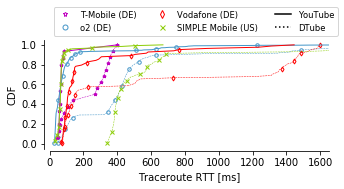

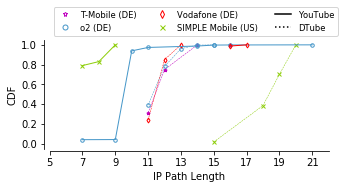

In [86]:
for (metric, col) in [('Traceroute RTT [ms]', 'rttMs'), ('IP Path Length', 'hop_count')]:
    
    dtube_tm = Cdf.MakeCdfFromList(dt_tr[dt_tr['provider'] == 'T-Mobile (DE)'][col].dropna())
    dtube_o2 = Cdf.MakeCdfFromList(dt_tr[dt_tr['provider'] == 'o2 (DE)'][col].dropna())
    dtube_vf = Cdf.MakeCdfFromList(dt_tr[dt_tr['provider'] == 'Vodafone (DE)'][col].dropna())
    dtube_sm = Cdf.MakeCdfFromList(dt_tr[dt_tr['provider'] == 'SIMPLE Mobile (US)'][col].dropna())
    
    youtube_tm = Cdf.MakeCdfFromList(yt_tr[yt_tr['provider'] == 'T-Mobile (DE)'][col].dropna())
    youtube_o2 = Cdf.MakeCdfFromList(yt_tr[yt_tr['provider'] == 'o2 (DE)'][col].dropna())
    youtube_vf = Cdf.MakeCdfFromList(yt_tr[yt_tr['provider'] == 'Vodafone (DE)'][col].dropna())
    youtube_sm = Cdf.MakeCdfFromList(yt_tr[yt_tr['provider'] == 'SIMPLE Mobile (US)'][col].dropna())

    cdfs = [dtube_tm,
            dtube_o2,
            dtube_vf,
            dtube_sm,
            youtube_tm,
            youtube_o2,
            youtube_vf,
            youtube_sm
           ]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(8):
        ax.plot(cdfs[i].xs, cdfs[i].ps,
                marker = prov_markers[i%4], 
                linewidth = 0.5 if i<4 else 1, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = prov_colors[i%4],
                markevery=max(1, int(len(cdfs[i].xs)/10)),
                linestyle = '--' if i<4 else '-'
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], 'by-providers/' + metric.split(' [')[0].replace(' ', '-').lower(),
                            metric, '%s + %s' % ('DTube' if i<4 else 'YouTube', prov_labels[i%4]))
        

    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_ylim([-0.05, 1.05])
    
    if 'Path' in metric:
        ax.set_xlim([5, 22])
        ax.set_xticks(np.arange(5,23,2))
    elif 'RTT' in metric:
        ax.set_xlim([0, 1650])
    
    ax.legend(handles=custom_handles, loc = 'lower left', fontsize = 'small', ncol=3, bbox_to_anchor=(0,1))

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    
    if save_figures:
        fig.savefig('figures/providers/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), bbox_inches = 'tight')

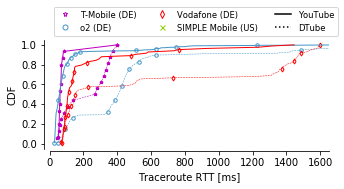

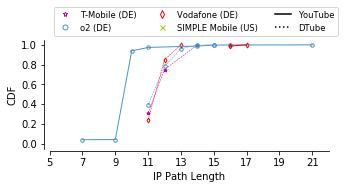

In [87]:
for (metric, col) in [('Traceroute RTT [ms]', 'rttMs'), ('IP Path Length', 'hop_count')]:
    
    dtube_tm = Cdf.MakeCdfFromList(dt_tr_eu[dt_tr_eu['provider'] == 'T-Mobile (DE)'][col].dropna())
    dtube_o2 = Cdf.MakeCdfFromList(dt_tr_eu[dt_tr_eu['provider'] == 'o2 (DE)'][col].dropna())
    dtube_vf = Cdf.MakeCdfFromList(dt_tr_eu[dt_tr_eu['provider'] == 'Vodafone (DE)'][col].dropna())
    dtube_sm = Cdf.MakeCdfFromList(dt_tr_eu[dt_tr_eu['provider'] == 'SIMPLE Mobile (US)'][col].dropna())
    
    youtube_tm = Cdf.MakeCdfFromList(yt_tr_eu[yt_tr_eu['provider'] == 'T-Mobile (DE)'][col].dropna())
    youtube_o2 = Cdf.MakeCdfFromList(yt_tr_eu[yt_tr_eu['provider'] == 'o2 (DE)'][col].dropna())
    youtube_vf = Cdf.MakeCdfFromList(yt_tr_eu[yt_tr_eu['provider'] == 'Vodafone (DE)'][col].dropna())
    youtube_sm = Cdf.MakeCdfFromList(yt_tr_eu[yt_tr_eu['provider'] == 'SIMPLE Mobile (US)'][col].dropna())

    cdfs = [dtube_tm,
            dtube_o2,
            dtube_vf,
            dtube_sm,
            youtube_tm,
            youtube_o2,
            youtube_vf,
            youtube_sm
           ]
    
    fig, ax = plt.subplots(figsize=(5,2))

    for i in range(8):
        ax.plot(cdfs[i].xs, cdfs[i].ps,
                marker = prov_markers[i%4], 
                linewidth = 0.5 if i<4 else 1, 
                markersize = 3.5, 
                fillstyle = 'none', 
                color = prov_colors[i%4],
                markevery=max(1, int(len(cdfs[i].xs)/10)),
                linestyle = '--' if i<4 else '-'
               )
        
        if export_cdf:
            export_cdf_dist(cdfs[i], 'by-providers/eu-only' + metric.split(' [')[0].replace(' ', '-').lower(),
                            metric, '%s + %s' % ('DTube' if i<4 else 'YouTube', prov_labels[i%4]), )
        

    # PLOT FORMATTING
    ax.set_xlabel('%s' % metric)
    ax.set_ylabel('CDF')
    ax.set_ylim([-0.05, 1.05])
    
    if 'Path' in metric:
        ax.set_xlim([5, 22])
        ax.set_xticks(np.arange(5,23,2))
    elif 'RTT' in metric:
        ax.set_xlim([0, 1650])
    
    ax.legend(handles=custom_handles, loc = 'lower left', fontsize = 'small', ncol=3, bbox_to_anchor=(0,1))

    yticks = np.arange(0.0, 1.01, 0.2)
    ax.set_yticks(yticks)
    ax.grid(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.spines['left'].set_position(('axes', -0.02))
    
    if save_figures:
        fig.savefig('figures/providers/eu-only/%s-cdf.pdf' % metric.split(' [')[0].replace(' ', '-').lower(),
                    bbox_inches = 'tight')

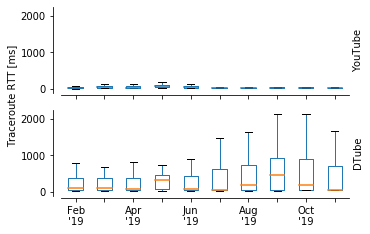

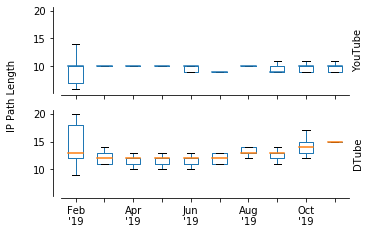

In [88]:
for (metric, col) in [('Traceroute RTT [ms]', 'rttMs'), ('IP Path Length', 'hop_count')]:
    ts_fig, (ts_ax_yt, ts_ax_dt) = plt.subplots(figsize = (5, 3.5), nrows = 2, sharey = True)
    bp_yt = yt_tr.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_yt, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')
    bp_dt = dt_tr.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_dt, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    for (platform, bp) in [('yt', bp_yt), ('dt', bp_dt)]:
        for key in bp.keys():
            for item in bp[key]['medians']:
                if platform == 'yt':
                    item.set_color('C0')
                if platform == 'dt':
                    item.set_color('C1')

    # PLOT FORMATTING
    ts_fig.suptitle('')
    
    for platform, ts_ax in [('YouTube', ts_ax_yt), ('DTube', ts_ax_dt)]:
        ts_ax.set_title('')
        ts_ax.set_xlabel('')

        major_ticklabels = ts_ax.xaxis.get_majorticklabels()
        for ticklabel in major_ticklabels:
            label = ticklabel.get_text()[1:-1]
            y, m = label.split(', ')
            y = y[-2:]
            if int(m) in [2, 4, 6, 8, 10, 12]:
                label = months[int(m)][:3] + '\n\'' + y[-2:] 
            else:
                label = ''
            ticklabel.set_text(label)

        ts_ax.grid(False)
        ts_ax.spines['right'].set_color('none')
        ts_ax.spines['top'].set_color('none')
        ts_ax.yaxis.set_ticks_position('left')
        ts_ax.xaxis.set_ticks_position('bottom')
        ts_ax.spines['bottom'].set_position(('axes', -0.03))
        ts_ax.spines['left'].set_position(('axes', -0.03))

        ts_ax.set_xticklabels(major_ticklabels, rotation = 0)
        
        ax1_ = ts_ax.twinx()
        ax1_.spines['right'].set_color('none')
        ax1_.spines['top'].set_color('none')
        ax1_.spines['left'].set_color('none')
        ax1_.spines['bottom'].set_color('none')
        ax1_.yaxis.set_ticks_position('none')
        ax1_.set_ylabel('%s' % platform)
        plt.setp(ax1_.get_yticklabels(), visible = False)
    
    ts_ax_yt.set_xticklabels('')
    
    ts_fig.text(-0.05, 0.55, '%s' % metric, va='center', rotation='vertical')

    if save_figures:
        ts_fig.savefig('figures/time-boxes/%s.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), 
                       bbox_inches = 'tight')
    plt.show()

plt.close('all')

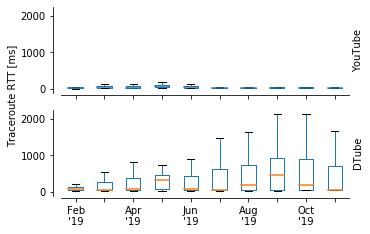

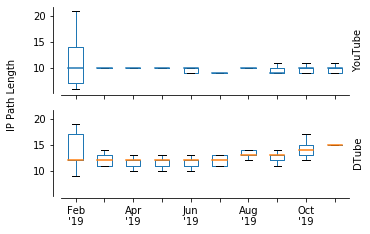

In [89]:
for (metric, col) in [('Traceroute RTT [ms]', 'rttMs'), ('IP Path Length', 'hop_count')]:
    ts_fig, (ts_ax_yt, ts_ax_dt) = plt.subplots(figsize = (5, 3.5), nrows = 2, sharey = True)
    bp_yt = yt_tr_eu.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_yt, sym = "", 
                    medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')
    bp_dt = dt_tr_eu.boxplot(column = [col], by = ['year', 'month'], ax = ts_ax_dt, sym = "", 
                        medianprops = { 'linewidth' : 1.5 }, return_type = 'dict')

    for (platform, bp) in [('yt', bp_yt), ('dt', bp_dt)]:
        for key in bp.keys():
            for item in bp[key]['medians']:
                if platform == 'yt':
                    item.set_color('C0')
                if platform == 'dt':
                    item.set_color('C1')

    ts_fig.suptitle('')
    
    for platform, ts_ax in [('YouTube', ts_ax_yt), ('DTube', ts_ax_dt)]:
        ts_ax.set_title('') 
        ts_ax.set_xlabel('')

        major_ticklabels = ts_ax.xaxis.get_majorticklabels()
        for ticklabel in major_ticklabels:
            label = ticklabel.get_text()[1:-1]
            y, m = label.split(', ')
            y = y[-2:]
            if int(m) in [2, 4, 6, 8, 10]:
                label = months[int(m)][:3] + '\n\'' + y[-2:] 
            else:
                label = ''
            ticklabel.set_text(label)

        ts_ax.grid(False)
        ts_ax.spines['right'].set_color('none')
        ts_ax.spines['top'].set_color('none')
        ts_ax.yaxis.set_ticks_position('left')
        ts_ax.xaxis.set_ticks_position('bottom')
        ts_ax.spines['bottom'].set_position(('axes', -0.03))
        ts_ax.spines['left'].set_position(('axes', -0.03))

        ts_ax.set_xticklabels(major_ticklabels, rotation = 0)
        
        ax1_ = ts_ax.twinx()
        ax1_.spines['right'].set_color('none')
        ax1_.spines['top'].set_color('none')
        ax1_.spines['left'].set_color('none')
        ax1_.spines['bottom'].set_color('none')
        ax1_.yaxis.set_ticks_position('none')
        ax1_.set_ylabel('%s' % platform)
        plt.setp(ax1_.get_yticklabels(), visible = False)
    
    ts_ax_yt.set_xticklabels('')
    
    ts_fig.text(-0.05, 0.55, '%s' % metric, va='center', rotation='vertical')

    if save_figures:
        ts_fig.savefig('figures/time-boxes/eu-only/%s.pdf' % metric.split(' [')[0].replace(' ', '-').lower(), 
                       bbox_inches = 'tight')
    plt.show()

plt.close('all')

In [90]:
trace = tr_df[(tr_df['hop_count'] > 0) & (tr_df['rttMs'] <= 5000)]

In [91]:
pd.crosstab(trace['platform'], trace['network_type'], margins=True)

network_type,cellular,wifi,All
platform,,,
dtube,634,1556,2190
youtube,1061,3822,4883
All,1695,5378,7073


In [92]:
print(pd.crosstab(trace['platform'], trace['network_type'], margins=True).to_latex())

\begin{tabular}{lrrr}
\toprule
network\_type &  cellular &  wifi &   All \\
platform &           &       &       \\
\midrule
dtube    &       634 &  1556 &  2190 \\
youtube  &      1061 &  3822 &  4883 \\
All      &      1695 &  5378 &  7073 \\
\bottomrule
\end{tabular}



In [112]:
pd.crosstab(msm_df['platform'], msm_df['provider'], margins=True)

provider,-,SIMPLE Mobile (US),T-Mobile (DE),Vodafone (DE),o2 (DE),All
platform,,,,,,
dtube,1820,200,233,87,474,2814
youtube,4074,199,462,83,919,5737
All,5894,399,695,170,1393,8551


In [121]:
print(pd.crosstab(msm_df['platform'], msm_df['provider'], margins=True).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
provider &     - &  SIMPLE Mobile (US) &  T-Mobile (DE) &  Vodafone (DE) &  o2 (DE) &   All \\
platform &       &                     &                &                &          &       \\
\midrule
dtube    &  1820 &                 200 &            233 &             87 &      474 &  2814 \\
youtube  &  4074 &                 199 &            462 &             83 &      919 &  5737 \\
All      &  5894 &                 399 &            695 &            170 &     1393 &  8551 \\
\bottomrule
\end{tabular}



In [119]:
trace_count = msm_df[msm_df['rttMs'] < 5000]

In [120]:
pd.crosstab(trace_count['platform'], trace_count['provider'], margins=True)

provider,-,SIMPLE Mobile (US),T-Mobile (DE),Vodafone (DE),o2 (DE),All
platform,,,,,,
dtube,1556,114,16,87,417,2190
youtube,3822,124,15,83,839,4883
All,5378,238,31,170,1256,7073


In [122]:
print(pd.crosstab(trace_count['platform'], trace_count['provider'], margins=True).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
provider &     - &  SIMPLE Mobile (US) &  T-Mobile (DE) &  Vodafone (DE) &  o2 (DE) &   All \\
platform &       &                     &                &                &          &       \\
\midrule
dtube    &  1556 &                 114 &             16 &             87 &      417 &  2190 \\
youtube  &  3822 &                 124 &             15 &             83 &      839 &  4883 \\
All      &  5378 &                 238 &             31 &            170 &     1256 &  7073 \\
\bottomrule
\end{tabular}

